# Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).
Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs.

In [1]:
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt

In [2]:
dataset = datasets.load_digits()
data = dataset.data
target = dataset.target
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [3]:
target

array([0, 1, 2, ..., 8, 9, 8])

### Шаг 1
Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score.

In [4]:
dtc = DecisionTreeClassifier()
dtc_def_score = cross_val_score(dtc, data, target, cv=10)
dtc_def_score.mean()

np.float64(0.8285754189944134)

### Шаг 2

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

In [5]:
bc = BaggingClassifier(dtc, n_estimators=100)
bc.fit(data, target)
bc_score = cross_val_score(bc, data, target, cv=10)
bc_score.mean()

np.float64(0.9248355058969585)

### Шаг 3
Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [6]:
sqrt_bc = BaggingClassifier(dtc, n_estimators=100, max_features=int(np.sqrt(len(data[0]))))
sqrt_bc_score = cross_val_score(sqrt_bc, data, target, cv=10, n_jobs=-1)
sqrt_bc_score.mean()

np.float64(0.9326784605834885)

### Шаг 4
Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков.

In [7]:
sqrt_dtc = DecisionTreeClassifier(max_features=int(np.sqrt(len(data[0]))))
bc_over_sqrt = BaggingClassifier(sqrt_dtc, n_estimators=100)
bc_over_sqrt_score = cross_val_score(bc_over_sqrt, data, target, cv=10, n_jobs=-1)
bc_over_sqrt_score.mean()

np.float64(0.9432371198013655)

### Шаг 5

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности постройте графики зависимости качества от значений параметров.

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера

  1. Случайный лес сильно переобучается с ростом количества деревьев
  2. При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев
  3. С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.
  4. При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.
  5. При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.
  6. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.
  7. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

2 3 4 7 

In [8]:
rfc = RandomForestClassifier()
rfc_score = cross_val_score(rfc, data, target, cv=10, n_jobs=-1)
rfc_score.mean()

np.float64(0.95268156424581)

#### Зависимость от количества деревьев

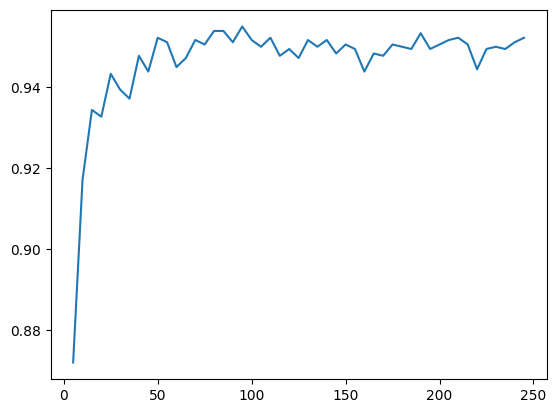

In [9]:
trees = [5*i for i in range(1, 50)]
scores = []
for amount in trees:
  rfc = RandomForestClassifier(n_estimators=amount)
  scores.append(cross_val_score(rfc, data, target, cv=10, n_jobs=-1).mean())
plt.plot(trees, scores)
plt.show()

#### Зависимость от количества признаков

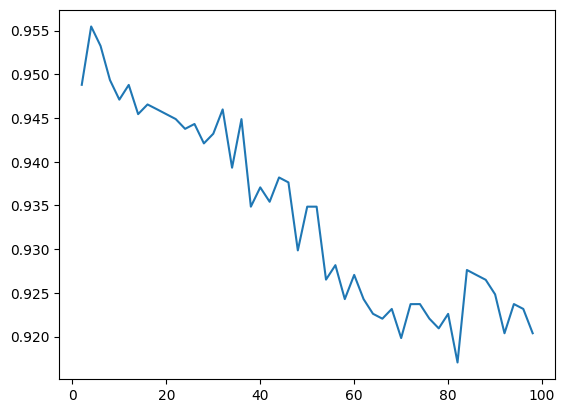

In [10]:
features = [2*i for i in range(1, 50)]
scores = []
for amount in features:
  rfc = RandomForestClassifier(n_estimators=100, max_features=amount)
  scores.append(cross_val_score(rfc, data, target, cv=10, n_jobs=-1).mean())
plt.plot(features, scores)
plt.show()

#### Зависимость от глубины деревьев

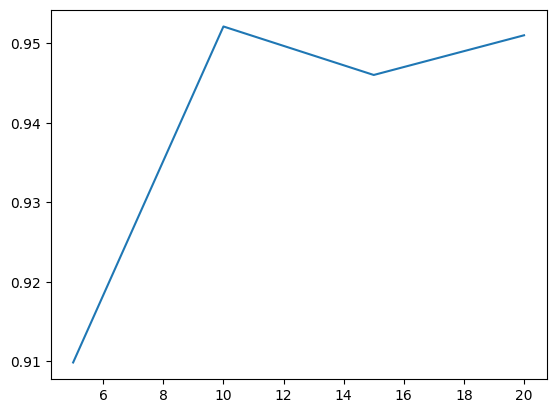

In [11]:
tree_depth = [5, 10, 15, 20, None]
scores = []
for amount in tree_depth:
  clf = RandomForestClassifier(n_estimators=100, max_depth=amount)
  scores.append(cross_val_score(clf, data, target, cv=10, n_jobs=-1).mean())
plt.plot(tree_depth, scores)
plt.show()